In [1]:
!pip install geopandas matplotlib contextily openeo


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


## Define an area of interest

In [5]:
aoi = {
    'east': 22.136334940987638,  # max longitude
    'south': 65.63560585326866,  # min latitude
    'west': 21.79257719972466,   # min longitude
    'north': 65.78212032521256   # max latitude
}

## Plot an area of interest

In [7]:
import folium
import io
import numpy as np
import openeo
import json
import rasterio
from pathlib import Path
from config import *
from demo_helpers import show_result
from demo_regions import s2,s3
from config import user,passwd,eo_service_url
from demo_regions import s2
from matplotlib import pyplot as plt
from IPython.display import display, IFrame

center_lat = (aoi['north'] + aoi['south']) / 2
center_lon = (aoi['east'] + aoi['west']) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=2, tiles="OpenStreetMap")

folium.Rectangle(
    bounds=[
        [aoi['south'], aoi['west']],
        [aoi['north'], aoi['east']]
    ],
    color="red",
    weight=2,
    fill=True,
    fill_opacity=0.2
).add_to(m)

## Save the map as an HTML file
#m.save("bounding_box_map.html")

# Display the map directly in the notebook
display(IFrame("bounding_box_map.html", width=700, height=500))

## OpenEO utility functions

In [24]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

connection = openeo.connect(eo_service_url)

print(eo_service_url)
print(user)
print(connection.authenticate_basic(username=user, password=passwd))

def poll_job(job, polling_interval=10):
    while True:
        status = job.status()
    
        print(f"Job status: {status}")
        
        if status == "finished":
            print("Job has finished.")
            break
            
        time.sleep(polling_interval)

def plot_file(file_path: str, title: str=""):
    with rasterio.open(file_path) as im:
        r = im.read(1)
        g = im.read(2)
        b = im.read(3)

        r_normalized = normalize(r)
        g_normalized = normalize(g)
        b_normalized = normalize(b)

        rgb = np.dstack((r_normalized, g_normalized, b_normalized))

    _, ax = plt.subplots(figsize=(40, 40))
    ax.imshow(rgb)
    ax.set_title(title)
    plt.show()

def convert_gtiff_to_img(file_path: str, output_png_path: str, title: str=""):
    # Open the GeoTIFF file
    with rasterio.open(file_path) as im:
        r = im.read(1)
        g = im.read(2)
        b = im.read(3)

        r_normalized = normalize(r)
        g_normalized = normalize(g)
        b_normalized = normalize(b)

        rgb = np.dstack((r_normalized, g_normalized, b_normalized))

    plt.imsave(output_png_path, rgb)

def normalize(array):
    array_min, array_max = np.percentile(array, (1, 99))
    array = np.clip(array, array_min, array_max)
    return ((array - array_min) / (array_max - array_min) * 255).astype(np.uint8)

class Dict2Class(object):
    def __init__(self, my_dict):

        for key in my_dict:
            if type(my_dict[key]) is dict:
                if key in ["bbox", "timespans", "polygons"]:
                    my_dict[key] = Dict2Class(my_dict[key])
            setattr(self, key, my_dict[key])

s2 = {
    "s2_msi_l2a": "s2_msi_l2a",
    "bbox": {
    }
}
s2 = Dict2Class(s2)

https://openeo.digitalearth.se
testuser
<Connection to 'https://openeo.digitalearth.se/' with BasicBearerAuth>


## Create a new job

In [25]:
cube = connection.load_collection(collection_id=s2.s2_msi_l2a,
                         spatial_extent=aoi,
                         temporal_extent=["2024-08-02T00:00:00Z", "2024-08-10T10:00:00Z"],
                         bands=['b04', 'b03', 'b02', 'b08'],
                        )

job = cube.create_job(out_format="gtiff",
    title= "Max time demo job1",
    description = "This job was created from a notebook")

print("Creating OpenEO job, ID=", job.job_id)

Creating OpenEO job, ID= 9b82a468-33d1-4e1c-873e-de666e69d914


## Start and wait

In [26]:
print("Starting OpenEO job, ID=", job.job_id)
print("Waiting ...")
job.start_and_wait()
poll_job(job)

results = job.get_results()
results.get_metadata()
results.download_files("data/out")

Starting OpenEO job, ID= 9b82a468-33d1-4e1c-873e-de666e69d914
Waiting ...
0:00:00 Job '9b82a468-33d1-4e1c-873e-de666e69d914': send 'start'
0:00:00 Job '9b82a468-33d1-4e1c-873e-de666e69d914': running (progress 0.0%)
0:00:05 Job '9b82a468-33d1-4e1c-873e-de666e69d914': running (progress 0.0%)
0:00:11 Job '9b82a468-33d1-4e1c-873e-de666e69d914': running (progress 0.0%)
0:00:19 Job '9b82a468-33d1-4e1c-873e-de666e69d914': running (progress 0.0%)
0:00:29 Job '9b82a468-33d1-4e1c-873e-de666e69d914': finished (progress 0.0%)
Job status: finished
Job has finished.


[PosixPath('data/out/process.json'),
 PosixPath('data/out/out_2024_08_05T10_06_01.tif'),
 PosixPath('data/out/out_2024_08_06T10_25_59.tif'),
 PosixPath('data/out/out_2024_08_08T10_20_21.tif'),
 PosixPath('data/out/out_2024_08_03T10_15_59.tif'),
 PosixPath('data/out/stac.json'),
 PosixPath('data/out/9b82a468-33d1-4e1c-873e-de666e69d914.txt'),
 PosixPath('data/out/py_proc_std_out.txt'),
 PosixPath('data/out/py_proc_std_err.txt'),
 PosixPath('data/out/job-results.json')]

## Cleanup

In [13]:
directory = Path('data/out')

print("Cleaning junk files ...")
for file in directory.iterdir():
    if file.is_file() and file.suffix != '.tif':
        file.unlink()
        print(f"Deleted: {file}")

print("Deletion complete.")

Cleaning junk files ...
Deleted: data/out/py_proc_std_err.txt
Deleted: data/out/stac.json
Deleted: data/out/process.json
Deleted: data/out/out_2024_08_05T10_06_01.jpg
Deleted: data/out/out_2024_08_03T10_15_59.jpg
Deleted: data/out/job-results.json
Deleted: data/out/out_2024_08_06T10_25_59.jpg
Deleted: data/out/py_proc_std_out.txt
Deleted: data/out/d704d241-91b3-4649-83dc-97dfa2194f8c.txt
Deleted: data/out/out_2024_08_08T10_20_21.jpg
Deletion complete.


## Convert to JPEG

In [14]:
# plot_file('data/out/out_2024_08_06T10_25_59.tif')
def convert_all_tif_to_jpg(directory: str):
    dir_path = Path(directory)
    
    for tif_file in dir_path.glob('*.tif'):
        jpg_file = tif_file.with_suffix('.jpg')
        convert_gtiff_to_img(str(tif_file), str(jpg_file))
        print(f"Converted {tif_file} to {jpg_file}")

print("Converting to GeoTiff to JPEG ...")

convert_all_tif_to_jpg('data/out')

Converting to GeoTiff to JPEG ...
Converted data/out/out_2024_08_06T10_25_59.tif to data/out/out_2024_08_06T10_25_59.jpg
Converted data/out/out_2024_08_08T10_20_21.tif to data/out/out_2024_08_08T10_20_21.jpg
Converted data/out/out_2024_08_03T10_15_59.tif to data/out/out_2024_08_03T10_15_59.jpg
Converted data/out/out_2024_08_05T10_06_01.tif to data/out/out_2024_08_05T10_06_01.jpg


In [33]:
!pip install s2cloudless scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 43.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.4/315.4 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 48.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


# Cloud detection

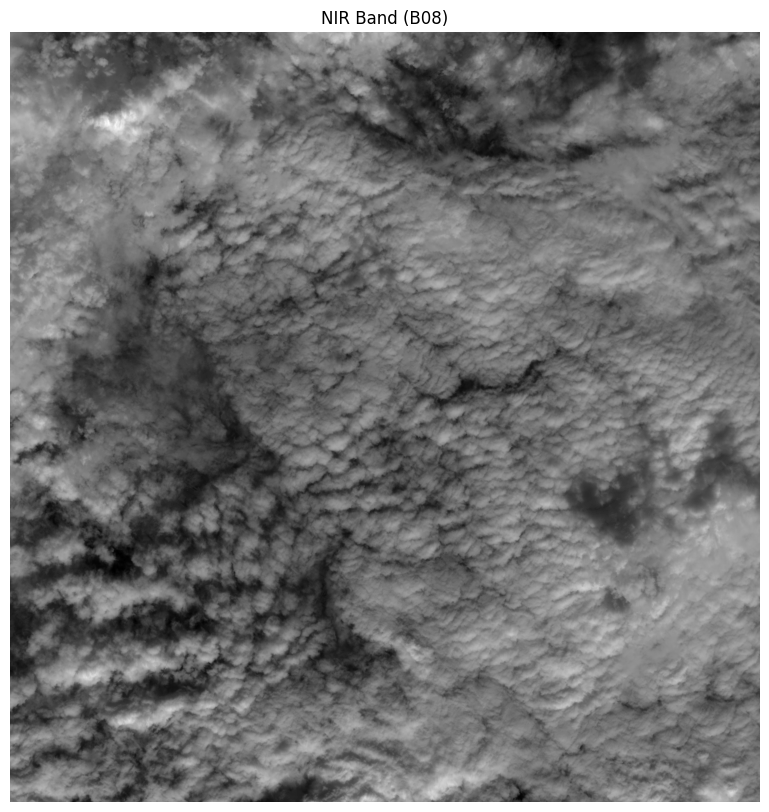

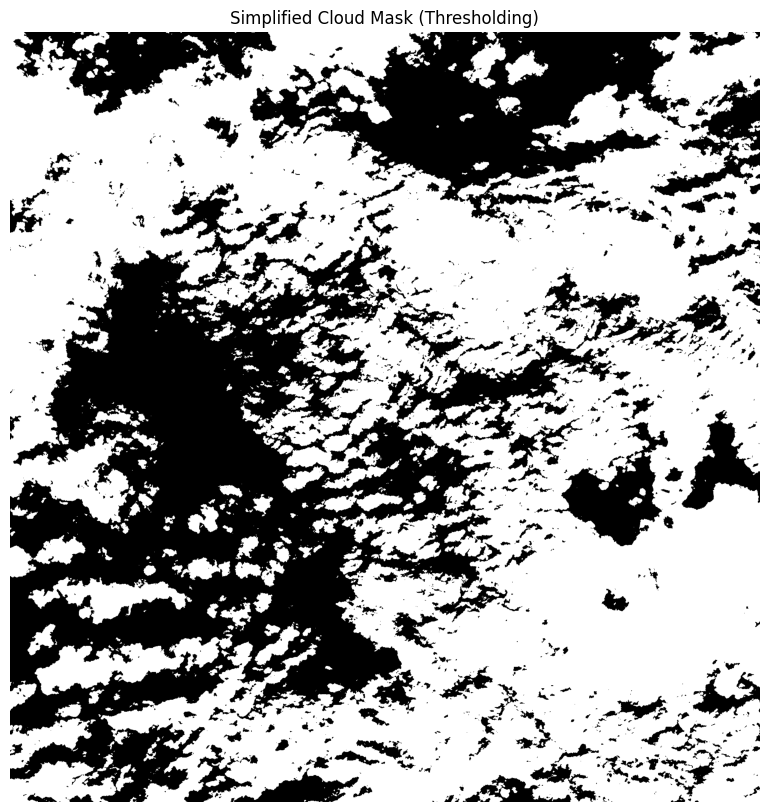

In [44]:
import rasterio
import numpy as np
import matplotlib.pypimport os
import csv

# Define the input directory and the path to the CSV file
input_directory = 'data/out'
csv_file_path = os.path.join(input_directory, 'cloud', 'cloud_coverage.csv')

# Set the cloud coverage threshold
cloud_coverage_threshold = 30.0

# List to hold filenames that meet the cloud coverage condition
files_above_threshold = []

# Read the CSV file and check for files with cloud coverage > 30%
with open(csv_file_path, mode='r') as csv_file:
    reader = csv.DictReader(csv_file)
    
    # Loop through each row in the CSV file
    for row in reader:
        # Get the filename and cloud coverage percentage
        filename = row['filename']
        cloud_coverage_percentage = float(row['cloud_coverage_percentage'])
        
        # Check if cloud coverage is greater than the threshold
        if cloud_coverage_percentage > cloud_coverage_threshold:
            files_above_threshold.append(filename)

# Print the list of files with cloud coverage > 30%
print("Files with cloud coverage greater than 30%:")
for filename in files_above_threshold:
    print(filename)
lot as plt
from skimage import filters

# File path to your GeoTIFF file
file_path = 'data/out/out_2024_08_03T10_15_59.tif'
#file_path = 'data/out/out_2024_08_06T10_25_59.tif'

# Function to read specific bands from a multi-band GeoTIFF
def read_bands(file_path, band_indices):
    with rasterio.open(file_path) as src:
        # Read the specified bands (rasterio is 1-based indexing)
        bands = src.read(band_indices)
    return bands

# Indices for B02, B03, B04, and B08 in the GeoTIFF
# (assuming they are in order: B04, B03, B02, B08)
b04_idx, b03_idx, b02_idx, b08_idx = 1, 2, 3, 4

# Read the necessary bands (B04=Red, B03=Green, B02=Blue, B08=NIR)
bands = read_bands(file_path, [b04_idx, b03_idx, b02_idx, b08_idx])

# Simplified cloud detection using a threshold on the NIR band (B08)
nir_band = bands[3]  # B08 (NIR)

# Apply Otsu's thresholding method (or manually define a threshold for cloud detection)
threshold_value = filters.threshold_otsu(nir_band)
cloud_mask = nir_band > threshold_value

# Function to plot the image
def plot_image(image, title, cmap='gray'):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot the original NIR band (B08) for comparison
plot_image(nir_band, 'NIR Band (B08)')

# Plot the cloud mask
plot_image(cloud_mask, 'Simplified Cloud Mask (Thresholding)')

# (Optional) Save the cloud mask as a GeoTIFF file
with rasterio.open(
        'simplified_cloud_mask.tif', 'w',
        driver='GTiff', 
        height=cloud_mask.shape[0],
        width=cloud_mask.shape[1],
        count=1, dtype=rasterio.uint8
) as dst:
    dst.write(cloud_mask.astype(np.uint8), 1)


In [45]:
manual_threshold_value = 0.3 * np.max(nir_band)  # Set manually based on your data
cloud_mask = nir_band > manual_threshold_value

# Calculate cloud coverage
total_pixels = cloud_mask.size
cloud_pixels = np.sum(cloud_mask)
cloud_coverage_percentage = (cloud_pixels / total_pixels) * 100
print(f"Cloud coverage: {cloud_coverage_percentage:.2f}%")

Cloud coverage: 90.78%


In [52]:
import os
import csv
import rasterio
import numpy as np
from PIL import Image

# Path to the directory containing the .tif files
input_directory = 'data/out'
output_directory = os.path.join(input_directory, 'cloud')
csv_file_path = os.path.join(output_directory, 'cloud_coverage.csv')

# Create the output directory if it does not exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Created directory: {output_directory}")

# Function to read specific bands from a multi-band GeoTIFF
def read_bands(file_path, band_indices):
    with rasterio.open(file_path) as src:
        bands = src.read(band_indices)
    return bands

# Function to generate and save cloud mask as both GeoTIFF and JPEG, and calculate cloud percentage
def generate_and_save_cloud_mask(file_path, output_tiff_path, output_jpeg_path):
    # Indices for B02, B03, B04, and B08 in the GeoTIFF
    b04_idx, b03_idx, b02_idx, b08_idx = 1, 2, 3, 4  # Update these indices as necessary

    # Read the necessary bands (B04=Red, B03=Green, B02=Blue, B08=NIR)
    bands = read_bands(file_path, [b04_idx, b03_idx, b02_idx, b08_idx])
    
    # Use the NIR band (B08) for cloud detection
    nir_band = bands[3]  # B08 (NIR)

    # Manual thresholding for cloud detection
    manual_threshold_value = 0.3 * np.max(nir_band)  # Adjust the threshold based on your data
    cloud_mask = nir_band > manual_threshold_value

    # Calculate cloud percentage
    total_pixels = cloud_mask.size
    cloud_pixels = np.sum(cloud_mask)
    cloud_coverage_percentage = (cloud_pixels / total_pixels) * 100
    print(f"Cloud coverage: {cloud_coverage_percentage:.2f}%")

    # Save the cloud mask as a GeoTIFF
    with rasterio.open(
            output_tiff_path, 'w',
            driver='GTiff',
            height=cloud_mask.shape[0],
            width=cloud_mask.shape[1],
            count=1, dtype=rasterio.uint8
    ) as dst:
        dst.write(cloud_mask.astype(np.uint8), 1)
    print(f"Cloud mask saved to: {output_tiff_path}")

    # Convert the cloud mask to JPEG format
    cloud_mask_normalized = (cloud_mask * 255).astype(np.uint8)  # Normalize mask to [0, 255]
    img = Image.fromarray(cloud_mask_normalized)
    img.save(output_jpeg_path, 'JPEG')
    print(f"Cloud mask JPEG saved to: {output_jpeg_path}")

    # Return cloud coverage percentage
    return cloud_coverage_percentage

# Prepare to write cloud coverage to a CSV file
with open(csv_file_path, mode='w', newline='') as csv_file:
    fieldnames = ['filename', 'cloud_coverage_percentage']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    # Loop through all .tif files in the input directory
    for filename in os.listdir(input_directory):
        if filename.endswith('.tif'):
            file_path = os.path.join(input_directory, filename)
            cloud_output_tiff_file = os.path.join(output_directory, f'cloud_{filename}')
            cloud_output_jpeg_file = os.path.join(output_directory, f'cloud_{filename.split(".")[0]}.jpeg')
            
            # Generate cloud mask and calculate cloud coverage percentage using manual threshold
            cloud_coverage_percentage = generate_and_save_cloud_mask(file_path, cloud_output_tiff_file, cloud_output_jpeg_file)
            
            # Write the filename and cloud coverage percentage to the CSV file
            writer.writerow({'filename': filename, 'cloud_coverage_percentage': cloud_coverage_percentage})

            print(f"Cloud coverage for {filename}: {cloud_coverage_percentage:.2f}% written to CSV")


Created directory: data/out/cloud
Cloud coverage: 3.41%
Cloud mask saved to: data/out/cloud/cloud_out_2024_08_06T10_25_59.tif
Cloud mask JPEG saved to: data/out/cloud/cloud_out_2024_08_06T10_25_59.jpeg
Cloud coverage for out_2024_08_06T10_25_59.tif: 3.41% written to CSV
Cloud coverage: 5.44%
Cloud mask saved to: data/out/cloud/cloud_out_2024_08_08T10_20_21.tif
Cloud mask JPEG saved to: data/out/cloud/cloud_out_2024_08_08T10_20_21.jpeg
Cloud coverage for out_2024_08_08T10_20_21.tif: 5.44% written to CSV
Cloud coverage: 90.78%
Cloud mask saved to: data/out/cloud/cloud_out_2024_08_03T10_15_59.tif
Cloud mask JPEG saved to: data/out/cloud/cloud_out_2024_08_03T10_15_59.jpeg
Cloud coverage for out_2024_08_03T10_15_59.tif: 90.78% written to CSV
Cloud coverage: 25.83%
Cloud mask saved to: data/out/cloud/cloud_out_2024_08_05T10_06_01.tif
Cloud mask JPEG saved to: data/out/cloud/cloud_out_2024_08_05T10_06_01.jpeg
Cloud coverage for out_2024_08_05T10_06_01.tif: 25.83% written to CSV


In [63]:
import os
import csv

# Define the input directory and the path to the CSV file
input_directory = 'data/out'
csv_file_path = os.path.join(input_directory, 'cloud', 'cloud_coverage.csv')

# Set the cloud coverage threshold
cloud_coverage_threshold = 30.0

# List to hold filenames that meet the cloud coverage condition
files_below_threshold = []

# Read the CSV file and check for files with cloud coverage < 30%
with open(csv_file_path, mode='r') as csv_file:
    reader = csv.DictReader(csv_file)
    
    # Loop through each row in the CSV file
    for row in reader:
        # Get the filename and cloud coverage percentage
        filename = row['filename']
        cloud_coverage_percentage = float(row['cloud_coverage_percentage'])

        print(filename, cloud_coverage_percentage)
        
        # Check if cloud coverage is less than the threshold
        if cloud_coverage_percentage < cloud_coverage_threshold:
            files_below_threshold.append(filename)

# Print the list of files with cloud coverage < 30%
print("Files with cloud coverage less than 30%:")
for filename in files_below_threshold:
    print(filename)


out_2024_08_06T10_25_59.tif 3.4118150684931505
out_2024_08_08T10_20_21.tif 5.444381024860477
out_2024_08_03T10_15_59.tif 90.78481735159816
out_2024_08_05T10_06_01.tif 25.827435312024356
Files with cloud coverage less than 30%:
out_2024_08_06T10_25_59.tif
out_2024_08_08T10_20_21.tif
out_2024_08_05T10_06_01.tif


CSV file with time series data saved to: data/out/ndvi/ndvi_time_series.csv
Time series plot saved to: data/out/ndvi/ndvi_time_series.png


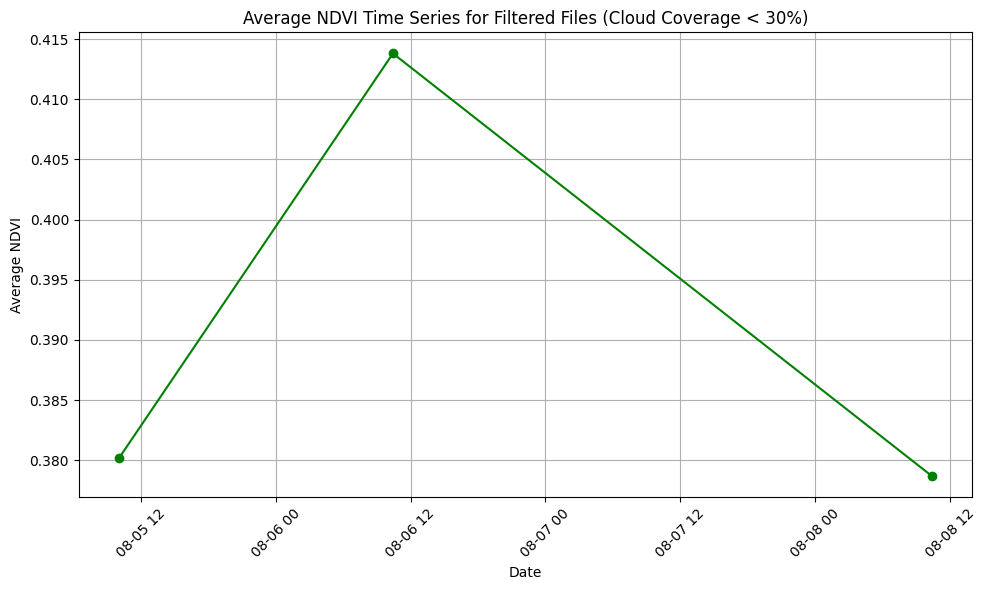

In [75]:
import os
import csv
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Define the input directory, output directory for NDVI plot, and the path to the CSV file
input_directory = 'data/out'
ndvi_output_directory = 'data/out/ndvi'
csv_file_path = os.path.join(input_directory, 'cloud', 'cloud_coverage.csv')

# Create the output directory for the plot and CSV if it does not exist
if not os.path.exists(ndvi_output_directory):
    os.makedirs(ndvi_output_directory)
    print(f"Created directory: {ndvi_output_directory}")

# Set the cloud coverage threshold
cloud_coverage_threshold = 30.0

# List to hold filenames and dates for files with cloud coverage < 30%
filtered_files = []

# Read the CSV file and filter for cloud coverage < 30%
with open(csv_file_path, mode='r') as csv_file:
    reader = csv.DictReader(csv_file)
    
    # Loop through each row in the CSV file
    for row in reader:
        filename = row['filename']
        cloud_coverage_percentage = float(row['cloud_coverage_percentage'])
        
        # Check if cloud coverage is less than the threshold
        if cloud_coverage_percentage < cloud_coverage_threshold:
            # Extract the date part from the filename (format: out_YYYY_MM_DDTHH_MM_SS.tif)
            try:
                # Split filename to get the date part between 'out_' and '.tif'
                date_str = filename.split('out_')[1].replace('.tif', '')  # Extracting '2024_08_06T10_25_59'
                date = datetime.strptime(date_str, "%Y_%m_%dT%H_%M_%S")  # Correct format for '2024_08_06T10_25_59'
                filtered_files.append((filename, date))
            except Exception as e:
                print(f"Error parsing date from filename {filename}: {e}")

# Function to read the necessary bands from a multi-band GeoTIFF
def read_bands(file_path):
    with rasterio.open(file_path) as src:
        # Read the RED and NIR bands (B04=Red, B08=NIR)
        red_band = src.read(1)  # Assuming B04 is the first band
        nir_band = src.read(4)  # Assuming B08 is the fourth band
    return red_band, nir_band

# Function to calculate NDVI
def calculate_ndvi(nir_band, red_band):
    ndvi = (nir_band.astype(float) - red_band.astype(float)) / (nir_band.astype(float) + red_band.astype(float) + 1e-10)  # Avoid division by zero
    return ndvi

# List to hold average NDVI values and corresponding dates
average_ndvi_values = []
dates = []
csv_data = []

# Loop through the filtered files and calculate the average NDVI for each
for filename, date in filtered_files:
    file_path = os.path.join(input_directory, filename)
    
    # Read RED and NIR bands
    red_band, nir_band = read_bands(file_path)
    
    # Calculate NDVI
    ndvi = calculate_ndvi(nir_band, red_band)
    
    # Calculate the average NDVI for the image
    average_ndvi = np.nanmean(ndvi)  # Use nanmean to ignore NaN values if present
    average_ndvi_values.append(average_ndvi)
    dates.append(date)
    
    # Add data to CSV list
    csv_data.append({'date': date.strftime("%Y-%m-%d %H:%M:%S"), 'filename': filename, 'ndvi': average_ndvi})

# Write the time series data to CSV file
csv_output_file = os.path.join(ndvi_output_directory, 'ndvi_time_series.csv')
with open(csv_output_file, mode='w', newline='') as csv_file:
    fieldnames = ['date', 'filename', 'ndvi']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(csv_data)

print(f"CSV file with time series data saved to: {csv_output_file}")

# Check if there are valid NDVI values to plot
if len(dates) > 0 and len(average_ndvi_values) > 0:
    # Sort the NDVI values and dates by the date
    sorted_data = sorted(zip(dates, average_ndvi_values))
    dates, average_ndvi_values = zip(*sorted_data)

    # Plotting the time series of average NDVI values
    plt.figure(figsize=(10, 6))
    plt.plot(dates, average_ndvi_values, marker='o', linestyle='-', color='green')
    plt.xlabel('Date')
    plt.ylabel('Average NDVI')
    plt.title('Average NDVI Time Series for Filtered Files (Cloud Coverage < 30%)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the plot as an image in the 'data/out/ndvi' directory
    plot_output_file = os.path.join(ndvi_output_directory, 'ndvi_time_series.png')
    plt.savefig(plot_output_file)
    print(f"Time series plot saved to: {plot_output_file}")

    # Show the plot (optional)
    plt.show()

else:
    print("No valid files with dates or NDVI values for plotting.")


In [89]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import os

def send_email(to_email, subject, body):
    # Email credentials from environment variables
    smtp_server = os.getenv('SMTP_SERVER', 'smtp.gmail.com')
    smtp_port = os.getenv('SMTP_PORT', 587)
    #smtp_user = os.getenv('SMTP_USER')  # Your email address
    smtp_user = "XXX"
    #smtp_password = os.getenv('SMTP_PASSWORD')  # Your email password or app-specific password
    smtp_password = "XXX"
    
    # Set up the email server
    server = smtplib.SMTP(smtp_server, smtp_port)
    server.starttls()  # Use TLS encryption
    server.login(smtp_user, smtp_password)

    # Create email
    msg = MIMEMultipart()
    msg['From'] = smtp_user
    msg['To'] = to_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))

    # Send the email
    server.sendmail(smtp_user, to_email, msg.as_string())
    server.quit()

    print(f"Email sent to {to_email} successfully.")

send_email(
    to_email="johan.kristiansson@ri.se",
    subject="NDVI Processing Completed",
    body="Your NDVI time series analysis is completed. Please check the data in your NDVI directory."
)

Email sent to johan.kristiansson@ri.se successfully.


In [90]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
import os

def send_email(to_email, subject, body, attachments=None):
    # Email credentials from environment variables
    smtp_server = os.getenv('SMTP_SERVER', 'smtp.gmail.com')
    smtp_port = os.getenv('SMTP_PORT', 587)
    #smtp_user = os.getenv('SMTP_USER')  # Your email address
    smtp_user = "XXX"
    #smtp_password = os.getenv('SMTP_PASSWORD')  # Your email password or app-specific password
    smtp_password = "XXX"
    
    # Set up the email server
    server = smtplib.SMTP(smtp_server, smtp_port)
    server.starttls()  # Use TLS encryption
    server.login(smtp_user, smtp_password)

    # Create email
    msg = MIMEMultipart()
    msg['From'] = smtp_user
    msg['To'] = to_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))

    # Attach files
    if attachments:
        for file_path in attachments:
            # Open the file in binary mode
            with open(file_path, 'rb') as attachment:
                # Create a MIMEBase object
                mime_base = MIMEBase('application', 'octet-stream')
                mime_base.set_payload(attachment.read())
                encoders.encode_base64(mime_base)

                # Add header to the attachment
                filename = os.path.basename(file_path)
                mime_base.add_header(
                    'Content-Disposition',
                    f'attachment; filename={filename}'
                )

                # Attach the file to the email
                msg.attach(mime_base)

    # Send the email
    server.sendmail(smtp_user, to_email, msg.as_string())
    server.quit()

    print(f"Email with attachments sent to {to_email} successfully.")

# File paths for the attachments
ndvi_plot = 'data/out/ndvi/ndvi_time_series.png'
ndvi_csv = 'data/out/ndvi/ndvi_time_series.csv'

# Send email with both attachments
send_email(
    to_email="johan.kristiansson@ri.se",
    subject="NDVI Processing Completed",
    body="Your NDVI time series analysis is completed. Please find the attached time series plot and CSV file.",
    attachments=[ndvi_plot, ndvi_csv]
)


Email with attachments sent to johan.kristiansson@ri.se successfully.
